# Доп вычисление при подготовке защиты решения

In [270]:
import pickle

# Загружаем сохраненный файл
with open(r'.\data\attempts\20_catb_p2_5nn.pkl', 'rb') as pkl_file:
    p1 = pickle.load(pkl_file)
    
p1[0].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 10,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 6,
 'border_count': 90,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.10000000149011612,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'MVS',
 'max_leaves': 64}

**загрузка данных**

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_FILE_NAME = '\\1_X_shuffeled.csv'
Y_FILE_NAME = '\\1_y_shuffeled.csv'

# X = data_train.drop('NTG',axis=1)
# y = data_train['NTG']
X = pd.read_csv(r'C:\Users\snkna\YA_profi_2020_semi_final\data\attempts'+ X_FILE_NAME)
y = pd.read_csv(r'C:\Users\snkna\YA_profi_2020_semi_final\data\attempts'+Y_FILE_NAME)
x_train,x_valid,y_train,y_valid = train_test_split(X, y, test_size=0.25, random_state=240,shuffle=True)
X

,X,Y
0,216,908
1,209,916
2,244,921
3,232,917
4,208,919
...,...,...
133,205,911
134,219,907
135,231,920
136,225,922


# Расчет метрик качества для spline и rbf интерполяций

**grid nearest**

In [69]:
from scipy.interpolate import griddata
import numpy as np
import pandas as pd


grid_x, grid_y = np.mgrid[201:246:46j, 901:930:30j]
grid_z0 = griddata(x_train, y_train, (grid_x, grid_y), method='nearest')
grid_z0_df = pd.DataFrame(grid_z0.reshape(-1,30),columns=range(901,931),index=range(201,247))

data_test0 = x_valid
l = []
for i in data_test0.index:
    l.append(grid_z0_df.loc[ data_test0.loc[i,'X'], data_test0.loc[i,'Y']])

data_test12 = data_test0.copy()
data_test12['NTG'] = l
data_test12.head(3)

,X,Y,NTG
95,204,907,0.2517
27,244,911,0.2463
84,207,912,0.3054


In [68]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_valid,data_test12[['NTG']]))

0.06571083841889622

**rbf function='multiquadric', smooth=0**

In [72]:
from scipy.interpolate import Rbf


rbfi = Rbf(x_train['X'], x_train['Y'], y_train['NTG'])  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(x_valid['X'], x_valid['Y'])   # interpolated values

data_test13 = data_test0.copy()
data_test13['NTG'] = di
np.sqrt(mean_squared_error(y_valid,data_test13[['NTG']]))

0.0764165513802735

**rbf function='multiquadric', smooth=1**

In [75]:
rbfi = Rbf(x_train['X'], x_train['Y'], y_train['NTG'], function='multiquadric', smooth=1)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di2 = rbfi(x_valid['X'], x_valid['Y'])   # interpolated values

data_test14 = data_test0.copy()
data_test14['NTG'] = di2
np.sqrt(mean_squared_error(y_valid,data_test14[['NTG']]))

0.0554378492937172

**rbf function='linear', smooth=1**

In [76]:
rbfi = Rbf(x_train['X'], x_train['Y'], y_train['NTG'], function='linear', smooth=1)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di2 = rbfi(x_valid['X'], x_valid['Y'])   # interpolated values

data_test14 = data_test0.copy()
data_test14['NTG'] = di2
np.sqrt(mean_squared_error(y_valid,data_test14[['NTG']]))

0.05458394254877339

## Тестирование идей для улучшений

### полиномиальные признаки со степенью 11 и признаками 5 ближайших скважин

In [80]:
# Заново загрузим данные для чистоты эксперимента
import pandas as pd
import numpy as np

data_train = pd.read_csv(r'.\data\Training_wells.csv')
print('\033[1mРазмер набора данных:\033[0m',data_train.shape)
print('\033[1mПропуски:\n\033[0m',data_train.isnull().sum())

#Видно, что X и Y - это разделенный по '-' столбец Well. Проверю, что данные совпадают
data_train['X_splitted'] = data_train['Well'].str.split('-',expand=True)[0].astype('int')
print('\033[1mX и X извлеченные совпадают:\033[0m',(data_train['X']==data_train['X_splitted']).value_counts()[1]==data_train.shape[0])
data_train['Y_splitted'] = data_train['Well'].str.split('-',expand=True)[1].astype('int')
print('\033[1mY и Y извлеченные совпадают:\033[0m',(data_train['Y']==data_train['Y_splitted']).value_counts()[1]==data_train.shape[0])

#Тк данные совпадают, можно избавиться от лишних, созданных столбцов
data_train.drop(['X_splitted','Y_splitted','Well'],axis=1,inplace=True)

print('\033[1mТипы данных:\n\033[0m',data_train.dtypes)
print('\033[1mУникальных X:\033[0m', len(data_train['X'].unique()))
print('\033[1mУникальных Y:\033[0m', len(data_train['Y'].unique()))
data_train.head()

Размер набора данных: (138, 4)
Пропуски:
 Well    0
X       0
Y       0
NTG     0
dtype: int64
X и X извлеченные совпадают: True
Y и Y извлеченные совпадают: True
Типы данных:
 X        int64
Y        int64
NTG    float64
dtype: object
Уникальных X: 43
Уникальных Y: 30


,X,Y,NTG
0,201,907,0.2006
1,201,914,0.3624
2,201,924,0.4381
3,202,922,0.4289
4,202,925,0.4021


In [295]:
import pandas as pd
import numpy as np

data_test0 = pd.read_csv(r'.\data\Empty_part.csv')
data_test = data_test0.copy()
print('\033[1mРазмер тесиового набора данных:\033[0m',data_test0.shape)
print('\033[1mПропуски:\n\033[0m',data_test0.isnull().sum())

#Видно, что X и Y - это разделенный по '-' столбец Well. Проверю, что данные совпадают
data_test['X_splitted'] = data_test['Well'].str.split('-',expand=True)[0].astype('int')
print('\033[1mX и X извлеченные совпадают:\033[0m',(data_test['X']==data_test['X_splitted']).value_counts()[1]==data_test.shape[0])
data_test['Y_splitted'] = data_test['Well'].str.split('-',expand=True)[1].astype('int')
print('\033[1mY и Y извлеченные совпадают:\033[0m',(data_test['Y']==data_test['Y_splitted']).value_counts()[1]==data_test.shape[0])

#Тк данные совпадают, можно избавиться от лишних, созданных столбцов
data_test.drop(['X_splitted','Y_splitted','Well'],axis=1,inplace=True)

print('\033[1mТипы данных:\n\033[0m',data_test.dtypes)
print('\033[1mУникальных X:\033[0m', len(data_test['X'].unique()))
print('\033[1mУникальных Y:\033[0m', len(data_test['Y'].unique()))
# data_test.head()

Размер тесиового набора данных: (1242, 3)
Пропуски:
 Well    0
X       0
Y       0
dtype: int64
X и X извлеченные совпадают: True
Y и Y извлеченные совпадают: True
Типы данных:
 X    int64
Y    int64
dtype: object
Уникальных X: 46
Уникальных Y: 30


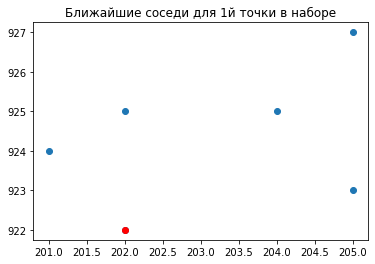

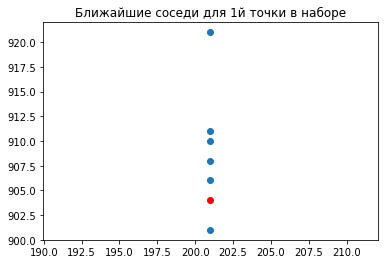

In [297]:
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split


def calculate_stats(data, column):
    """Рассчет статистик для выбранного столбца
       Результат: датафрейм"""
    
    data[column+'_mean'] = data[column].apply(lambda x: np.mean(x))
    data[column+'_median'] = data[column].apply(lambda x: np.median(x))
    data[column+'_std'] = data[column].apply(lambda x: np.std(x))
    data[column+'_scope'] = data[column].apply(lambda x: np.max(x)-np.min(x))
    data[column+'_skew'] = data[column].apply(lambda x: stats.skew(x))
    data[column+'_kurt'] = data[column].apply(lambda x: stats.kurtosis(x))
    return data

def extraxt_info(data,column,neighbours):
    for i in range(neighbours-1):
        data[str(i)+'_'+column] = data[column].apply(lambda x: x[i])
    return data


def generate_new_features(data,neighbours):
    df = data.copy()
    bt = BallTree(pd.DataFrame(data_train.drop('NTG',axis=1)), metric='euclidean')
    dist, ind = bt.query(df[['X','Y']], k=neighbours)
    #Индексы ближайших соседей, без 1го столбца, тк в нем исходная точка\
    ind_final = ind[:,1:]
    dist_final = dist[:,1:]
    df['Neighbours_idx'] = [d for d in ind_final]
    df['Neighbours_dist'] = [d for d in dist_final]
    df['Neighbours_NTG'] = [list(data_train.loc[d,'NTG']) for d in df['Neighbours_idx']]
    plt.scatter(df.iloc[ind[3],0],df.iloc[ind[3],1])
    plt.scatter(df.iloc[3,0],df.iloc[3,1],color='r')
    plt.title('Ближайшие соседи для 1й точки в наборе')
    plt.show()
    #Рассчит статистик
    df =  calculate_stats(df,'Neighbours_NTG')
    df =  calculate_stats(df,'Neighbours_dist')
    #Извлечение инфо о ближайших скважин
    extraxt_info(df,'Neighbours_dist',neighbours)
    extraxt_info(df,'Neighbours_NTG',neighbours)
    #Удаление лишних столбцов
    df.drop([ 'Neighbours_idx', 'Neighbours_dist', 'Neighbours_NTG'],axis=1,inplace=True)
    return df





data_train_with_15neighbours_stats = generate_new_features(data_train,6)
data_test_with_15neighbours_stats = generate_new_features(data_test,6)


def nn_poly_concat(deg,nn_set,data_set):
    from sklearn.preprocessing import PolynomialFeatures
    
    
    poly =  PolynomialFeatures(degree=deg,include_bias=False)
    
    poly_df = pd.DataFrame(poly.fit_transform(data_set))
    poly_df.columns= poly.get_feature_names(data_set.columns)
    poly_df.drop(['X','Y'],axis=1,inplace=True)  
    poly_nn_test = pd.concat([poly_df,nn_set],axis=1)
    return poly_nn_test




poly8_15nn_set = nn_poly_concat(11,data_train_with_15neighbours_stats,data_train.drop('NTG',axis=1))
poly8_15nn_set_test = nn_poly_concat(11,data_test_with_15neighbours_stats,data_test)


X_poly8_15nn = poly8_15nn_set.drop('NTG',axis=1)
y_poly8_15nn = poly8_15nn_set['NTG']
x_train_p8_15nn,x_valid_p8_15nn,y_train_p8_15nn,y_valid_p8_15nnn = train_test_split(X_poly8_15nn, y_poly8_15nn, test_size=0.25, random_state=240,shuffle=True)

data_15nn_p8_shuffeled = poly8_15nn_set.sample(frac=1,random_state=0)
X_15nn_p8_shuffeled = data_15nn_p8_shuffeled.drop('NTG',axis=1)
y_15nn_p8_shuffeled = data_15nn_p8_shuffeled['NTG']

In [140]:

# Загружаем сохраненный файл
with open(r'.\data\attempts\16_rf_p8_nn15.pkl', 'rb') as pkl_file:
    p1 = pickle.load(pkl_file)
p1.fit(x_train_p8_15nn,y_train_p8_15nn)
pred_16 = p1.predict(x_valid_p8_15nn)
np.sqrt(mean_squared_error(y_valid_p8_15nnn,pred_16))

0.047517092304410036

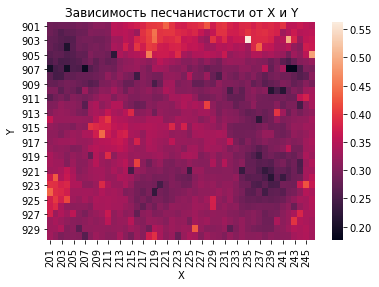

In [298]:
data_test = pd.read_csv(r'.\data\attempts\6_data_test.csv')
data_test['NTG'] = p1.predict(poly8_15nn_set_test)
sns.heatmap(pd.pivot_table(pd.concat([data_test,data_train]), values='NTG', index=['Y'],
                    columns=['X'], aggfunc=np.sum))
plt.title('Зависимость песчанистости от X и Y')
plt.show()

### Многослойный перцептрон

In [255]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(x_train)
X_testscaled=sc_X.transform(x_valid)

clf = MLPRegressor(hidden_layer_sizes=(345,90,),activation='relu',max_iter=1000, random_state=0)
clf.fit(X_trainscaled,y_train)

pred_17 = clf.predict(X_testscaled)
np.sqrt(mean_squared_error(y_valid,pred_17))



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.05147056964569378

In [207]:
pred_17

array([0.3 , 0.3 , 0.32, 0.32, 0.29, 0.35, 0.3 , 0.34, 0.31, 0.33, 0.27,
       0.27, 0.28, 0.31, 0.32, 0.31, 0.3 , 0.33, 0.33, 0.33, 0.27, 0.31,
       0.33, 0.39, 0.33, 0.32, 0.3 , 0.34, 0.33, 0.34, 0.32, 0.32, 0.29,
       0.35, 0.32])

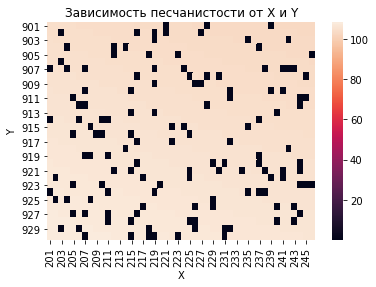

In [302]:
data_test = pd.read_csv(r'.\data\attempts\6_data_test.csv')
data_test['NTG'] = clf.predict(data_test[['X','Y']])
sns.heatmap(pd.pivot_table(pd.concat([data_test,data_train]), values='NTG', index=['Y'],
                    columns=['X'], aggfunc=np.sum))
plt.title('Зависимость песчанистости от X и Y')
plt.show()

### Визуализация полученных результатов

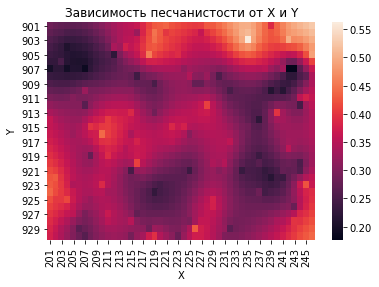

In [285]:
import seaborn as sns

data_test = pd.read_csv(r'.\data\attempts\15_data_test.csv')
sns.heatmap(pd.pivot_table(pd.concat([data_test,data_train]), values='NTG', index=['Y'],
                    columns=['X'], aggfunc=np.sum))
plt.title('Зависимость песчанистости от X и Y')
plt.show()

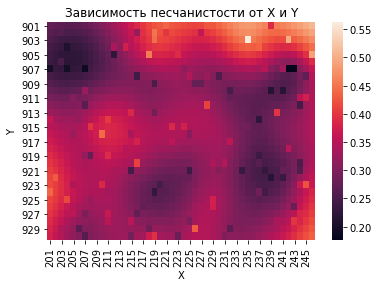

In [286]:
data_test = pd.read_csv(r'.\data\attempts\14_data_test.csv')
sns.heatmap(pd.pivot_table(pd.concat([data_test,data_train]), values='NTG', index=['Y'],
                    columns=['X'], aggfunc=np.sum))
plt.title('Зависимость песчанистости от X и Y')
plt.show()

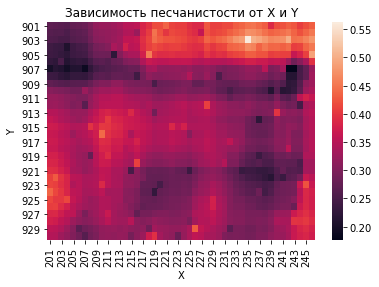

In [287]:
data_test = pd.read_csv(r'.\data\attempts\5_data_test.csv')
sns.heatmap(pd.pivot_table(pd.concat([data_test,data_train]), values='NTG', index=['Y'],
                    columns=['X'], aggfunc=np.sum))
plt.title('Зависимость песчанистости от X и Y')
plt.show()

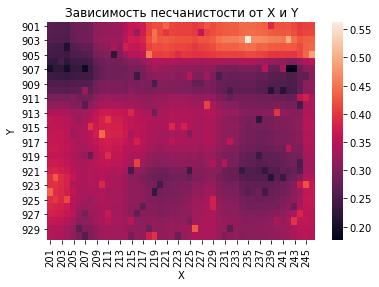

In [288]:
data_test = pd.read_csv(r'.\data\attempts\6_data_test.csv')
sns.heatmap(pd.pivot_table(pd.concat([data_test,data_train]), values='NTG', index=['Y'],
                    columns=['X'], aggfunc=np.sum))
plt.title('Зависимость песчанистости от X и Y')
plt.show()